In [30]:
import numpy as np
A = np.arange(4).reshape((2, 2))
d = np.array((1, 2))
D = np.diag(d)
B = D.dot(A)
d2 = np.expand_dims(d, -1)
C = d2 * A
E = np.dot(A, d)

# now try multiplying the same rank 2 matrix by a stack of vectors
I = np.eye(2)
I[1,1] += 1
B = np.arange(20).reshape((-1, 2))
G = np.einsum('jk,ik->ji', B, I)

# now try multiplying a stack of matrices by a stack of matrices
F = np.tile(I, (5,1,1))
for i in range(5):
    F[i,1,0] += i
H = np.einsum('ijk,ilk->ijl', F, F)

# now try multiplying a stack of matrices by a stack of diagonal (vectors, but interpreted as matrices)
D2 = np.tile(np.array((2, 1)), (5, 1))
U = np.einsum('ijk,ik->ijk', F, D2)

# now try multiplying by the diagonal
ones = np.ones(4).reshape((2, 2))
L = np.einsum('ij,j->ij', ones, d)

# PRINTS
print(H)

[[[ 1.  0.]
  [ 0.  4.]]

 [[ 1.  1.]
  [ 1.  5.]]

 [[ 1.  2.]
  [ 2.  8.]]

 [[ 1.  3.]
  [ 3. 13.]]

 [[ 1.  4.]
  [ 4. 20.]]]


In [44]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
import numpy as np
A = tf.constant(np.arange(8).reshape((2, 2, 2)))
d = tf.constant(np.arange(4).reshape((2, 2)) + 1)
D = tf.linalg.diag(d)
B = tf.matmul(D, A)
d2 = tf.expand_dims(d, -1)
C = d2 * A
E = tf.einsum('ijk,ik->ij', A, d)

# test making a stacked identity
I_ = tf.expand_dims(tf.eye(3), 0)
I = tf.tile(I_, (5, 1, 1))

# testing matrix_band_part
G = tf.constant(np.random.normal(size=(5, 3, 3)))
G_ld = tf.matrix_band_part(G, -1, 0) - tf.matrix_band_part(G, 0, 0)
G_ud = tf.einsum('ijk->ikj', G_ld)

with tf.Session() as sess:
    items = sess.run([G_ld, G_ud])
    
for i in items:
    print(i)
    print(i.shape)
    print('-' * 15)

[[[ 0.          0.          0.        ]
  [ 0.09625695  0.          0.        ]
  [ 1.13143356  2.05165023  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.90840584  0.          0.        ]
  [-1.07756304 -1.15731492  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.44025997  0.          0.        ]
  [ 0.79148105 -0.98379013  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.40358532  0.          0.        ]
  [-0.33460361  0.41942987  0.        ]]

 [[ 0.          0.          0.        ]
  [ 1.14782108  0.          0.        ]
  [-0.23457028  1.68843115  0.        ]]]
(5, 3, 3)
---------------
[[[ 0.          0.09625695  1.13143356]
  [ 0.          0.          2.05165023]
  [ 0.          0.          0.        ]]

 [[ 0.         -0.90840584 -1.07756304]
  [ 0.          0.         -1.15731492]
  [ 0.          0.          0.        ]]

 [[ 0.          0.44025997  0.79148105]
  [ 0.          0.         -0.98379013]
  [ 0.          0.          0.        ]]

In [3]:
# TEST IF eigh() IS DIFFERENTIABLE
A = tf.Variable(np.random.normal(size=(5, 5)))
A = tf.matmul(A, A, transpose_b=True)
e, v = tf.linalg.eigh(A)
loss = tf.linalg.norm(tf.einsum('ij,kj->ik', tf.einsum('ij,j->ij', v, e), v) - tf.cast(tf.eye(5), tf.float64))
e, v = e[::-1], v[:, ::-1]
error = tf.linalg.norm(tf.einsum('ij,kj->ik', tf.einsum('ij,j->ij', v, e), v) - A)

opt = tf.train.AdamOptimizer()
step = opt.minimize(loss)

# initialize
with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    for i in range(10000):
        loss_, error_, _ = sess.run([loss, error, step])
        if i % 1000 == 0:
            print(i, loss_, error_)
        
    A_ = sess.run(A)
    
print(A_)

Instructions for updating:
Colocations handled automatically by placer.
0 11.760283743371582 1.9680704425516214e-14
1000 1.0077671075094177 3.041364573118545e-15
2000 0.0006490576372173056 3.238326847240935e-15
3000 0.0006831574389143246 2.6165887157806812e-15
4000 0.0003786960826185274 1.8530224903112733e-15
5000 0.0012409560728562229 3.4553044170880418e-15
6000 0.00041810292434621893 1.8450371534837855e-15
7000 0.0012994607244076954 2.02460598468196e-15
8000 0.0004222112320581608 2.354972029295535e-15
9000 0.0004253922010568872 2.857467998512094e-15
[[ 1.00013381e+00  1.54636501e-04  3.41013977e-05 -2.01007911e-05
  -1.02447313e-04]
 [ 1.54636501e-04  9.99901111e-01  1.04682823e-04 -1.38055673e-04
   5.61349193e-05]
 [ 3.41013977e-05  1.04682823e-04  9.99951820e-01 -4.73678186e-04
   1.26969086e-04]
 [-2.01007911e-05 -1.38055673e-04 -4.73678186e-04  1.00000107e+00
   1.46778857e-04]
 [-1.02447313e-04  5.61349193e-05  1.26969086e-04  1.46778857e-04
   1.00005206e+00]]


In [4]:
# TEST MATRIX STACK x MATRIX STACK
n_stacks = 10
n = 10

# generate matrices
matrices = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    product = np.dot(matrix, matrix.T)
    matrices.append(matrix)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
product_stack = np.einsum('ijk,ilk->ijl', matrix_stack, matrix_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i,:,:])
    diffs.append(diff)
    
print(sum(diffs))

-3.728614639264549e-14


In [5]:
# TEST MATRIX STACK x VECTOR STACK (REPRESENTING DIAGONALS)
n_stacks = 10
n = 10

# generate matrices
matrices = []
diagonals = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    diagonal = np.random.normal(size=(n,))
    product = np.dot(matrix, np.diag(diagonal))
    matrices.append(matrix)
    diagonals.append(diagonal)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
diagonals_stack = np.concatenate([np.expand_dims(d, axis=0) for d in diagonals], axis=0)
product_stack = np.einsum('ijk,ik->ijk', matrix_stack, diagonals_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i,:,:])
    diffs.append(diff)
    
print(sum(diffs))

0.0


In [6]:
# TEST MATRIX STACK x VECTOR STACK (REPRESENTING ACTUAL VECTORS)
n_stacks = 10
n = 10

# generate matrices
matrices = []
vectors = []
products = []
for i in range(n_stacks):
    matrix = np.random.normal(size=(n, n))
    vector = np.random.normal(size=(n,))
    product = np.dot(matrix, vector)
    matrices.append(matrix)
    vectors.append(vector)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
vectors_stack = np.concatenate([np.expand_dims(v, axis=0) for v in vectors], axis=0)
product_stack = np.einsum('ijk,ik->ij', matrix_stack, vectors_stack)

diffs = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i])
    diffs.append(diff)
    
print(sum(diffs))

1.4155343563970746e-15


In [7]:
# check numpy broadcasting for row sums
n = 100
x = np.random.normal(size=(n, 100000)) ** 2
x /= np.expand_dims(np.sum(x, axis=1), -1)
print(np.sum(x))

99.99999999999991


In [8]:
# check tf broadcasting for row sums
n = 100
e = tf.constant(np.random.normal(size=(n, 10000)) ** 2)
eps = 1e-8
pre_e_t = 1/(e + eps)
e_t = pre_e_t / tf.expand_dims(tf.reduce_sum(pre_e_t, axis=1), -1) #*tf.expand_dims(tf.reduce_sum(e, axis=1), -1)
e_t_sum = tf.reduce_sum(e_t)
e_t_max = tf.maximum(e_t, 20)
with tf.Session() as sess:
    a = sess.run(e_t_max)

In [9]:
# test if our home-made distance function is correct
import numpy as np
from scipy.spatial.distance import cdist

d = 10
n_A = 150
n_B = 320
A = np.random.normal(size=(n_A, d))
B = np.random.normal(size=(n_B, d))

def pairwise_dists(A, B):
    r_A, r_B = np.sum(A*A, 1), np.sum(B*B, 1)

    # turn r into column vector
    r_A, r_B = np.reshape(r_A, [-1, 1]), np.reshape(r_B, [-1, 1])
    D = r_A - 2 * np.matmul(A, B.T) + np.transpose(r_B)
    
    return D

D1 = np.sqrt(pairwise_dists(A, B))
D2 = cdist(A, B)
print(np.linalg.norm(D1 - D2))

8.553964006570825e-14


In [10]:
top = tf.nn.top_k(-D1, k=1)
with tf.Session() as sess:
    A_ = sess.run(top)
    
print(A_)

TopKV2(values=array([[-2.44537239],
       [-2.28546664],
       [-2.49804553],
       [-2.69727917],
       [-2.34327027],
       [-2.45701333],
       [-2.17858248],
       [-1.85851193],
       [-1.71948367],
       [-2.33709568],
       [-1.4553285 ],
       [-2.0844648 ],
       [-1.37256518],
       [-2.40063863],
       [-1.7582271 ],
       [-1.71235601],
       [-2.00699359],
       [-1.42230478],
       [-2.54521191],
       [-1.60771558],
       [-2.50432414],
       [-2.41817711],
       [-2.8341398 ],
       [-2.20725158],
       [-2.15753482],
       [-1.94781869],
       [-2.18603305],
       [-2.72222387],
       [-1.53418906],
       [-2.31360497],
       [-1.72499956],
       [-2.78367804],
       [-1.60173161],
       [-1.97109294],
       [-1.67782871],
       [-1.52927164],
       [-2.52969121],
       [-1.97286167],
       [-2.93976396],
       [-2.27890204],
       [-2.14775047],
       [-2.54150774],
       [-2.00720442],
       [-2.74128223],
       [-1.3877362

In [29]:
D = pairwise_dists(A, A) + 1e-6

k = 2
vals, idxs = tf.nn.top_k(-D, k=k)
a = tf.reshape(vals, (-1, 1))
range_A = tf.expand_dims(tf.range(idxs.shape[0]), -1)
p = tf.expand_dims(tf.random.uniform(shape=(tf.shape(idxs)[0],), maxval=k, dtype=tf.dtypes.int32), -1)
p = tf.concat([range_A, p], axis=1)
idx = tf.gather_nd(idxs, p)
idx = tf.expand_dims(idx, -1)
A_ = tf.gather_nd(A, idx)
RES = tf.linalg.norm(A_ - A)

with tf.Session() as sess:
    RES_ = sess.run(a)
    
print(RES_)

[[-1.00000000e-06]
 [-6.35289845e+00]
 [-1.00000000e-06]
 [-5.85632158e+00]
 [-1.00000000e-06]
 [-7.60171136e+00]
 [-1.00000000e-06]
 [-8.70459523e+00]
 [-9.99999993e-07]
 [-8.73410105e+00]
 [-9.99999996e-07]
 [-8.27319074e+00]
 [-1.00000000e-06]
 [-6.76189716e+00]
 [-1.00000000e-06]
 [-5.44502321e+00]
 [-1.00000000e-06]
 [-4.83976945e+00]
 [-1.00000000e-06]
 [-3.71196200e+00]
 [-1.00000000e-06]
 [-3.18082104e+00]
 [-9.99999996e-07]
 [-3.33803091e+00]
 [-1.00000000e-06]
 [-1.85297291e+00]
 [-1.00000001e-06]
 [-6.04638950e+00]
 [-9.99999993e-07]
 [-5.58432629e+00]
 [-1.00000000e-06]
 [-2.63493481e+00]
 [-9.99999996e-07]
 [-7.05389345e+00]
 [-9.99999999e-07]
 [-2.84178788e+00]
 [-1.00000000e-06]
 [-8.94199301e+00]
 [-1.00000000e-06]
 [-2.79086236e+00]
 [-9.99999996e-07]
 [-8.24672681e+00]
 [-1.00000000e-06]
 [-8.25081610e+00]
 [-1.00000000e-06]
 [-6.68854601e+00]
 [-9.99999996e-07]
 [-5.61974655e+00]
 [-9.99999996e-07]
 [-7.57514739e+00]
 [-1.00000000e-06]
 [-3.06783817e+00]
 [-1.0000000

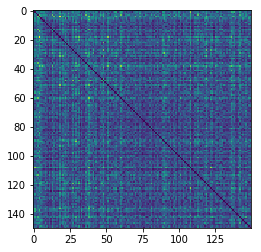

In [14]:
import matplotlib.pyplot as plt
plt.imshow(D)
plt.show()

In [26]:
small = tf.expand_dims(np.arange(9).reshape((3,3)), 1)
bigger = tf.tile(small, [1, 3, 1])
bigger = tf.reshape(bigger, (9, 3))
with tf.Session() as sess:
    bigger_ = sess.run(bigger)
    
print(bigger_)

[[0 1 2]
 [0 1 2]
 [0 1 2]
 [3 4 5]
 [3 4 5]
 [3 4 5]
 [6 7 8]
 [6 7 8]
 [6 7 8]]


In [43]:
n = 4
W = np.random.normal(size=(n, n))
W = np.dot(W, W.T)
print("symmetric (should be zero):", np.linalg.norm(W - W.T))
# normalize rows
row_norm = np.expand_dims(np.sum(W, axis=1), axis=-1)
col_norm = np.sum(W, axis=0)

print(np.sum(W / col_norm, axis=0))
print(np.sum(W / row_norm, axis=1))

W = W / row_norm / col_norm
print(np.sum(W, axis=1))
print(np.sum(W, axis=0))

W /= np.expand_dims(np.sum(W, axis=1), axis=-1)
print(np.sum(W, axis=1))
print(np.sum(W, axis=0))

symmetric (should be zero): 0.0
[1. 1. 1. 1.]
[1. 1. 1. 1.]
[ 3.06105521  2.12699085 24.73331476  8.68615588]
[ 3.06105521  2.12699085 24.73331476  8.68615588]
[1. 1. 1. 1.]
[0.45044643 0.34654615 2.34503677 0.85797065]


In [83]:
n = 4
W = tf.random.normal(shape=(n, n))
W = tf.matmul(W, W, transpose_b=True)
W = tf.Print(W, [tf.linalg.norm(W - tf.transpose(W))], "symmetric (should be zero):", summarize=n)
# normalize rows
row_norm = 1 / tf.reduce_sum(W, axis=1)
col_norm = 1 / tf.reduce_sum(W, axis=0)

W = tf.Print(W, [tf.reduce_sum(tf.einsum('i,ij->ij', row_norm, W), axis=1), tf.reduce_sum(tf.einsum('j,ij->ij', col_norm, W), axis=0)], summarize=n)

W2 = tf.einsum('j,ij->ij', col_norm, tf.einsum('i,ij->ij', row_norm, W))
W = W * tf.expand_dims(row_norm, -1) * col_norm
W = tf.Print(W, [tf.reduce_sum(W, axis=0), tf.reduce_sum(W, axis=1), tf.linalg.norm(W - W2), tf.linalg.norm(row_norm - col_norm)], summarize=n)

# check row normalization
row_norm = tf.sqrt(1 / tf.reduce_sum(W, axis=1))
row_norm = tf.Print(row_norm, [row_norm], 'row_norm ', summarize=n)
# W2 = tf.einsum('i,ij->ij', row_norm, W)
# W = W * tf.expand_dims(row_norm, -1)
# W = tf.Print(W, [tf.reduce_sum(W, axis=0), tf.reduce_sum(W, axis=1), tf.linalg.norm(W - W2), tf.linalg.norm(W - tf.transpose(W))], summarize=n)

# check D^{-1/2} W D^{-1/2} normalization
W2 = tf.einsum('j,ij->ij', row_norm, tf.einsum('i,ij->ij', row_norm, W))
W = tf.matmul(tf.diag(row_norm), tf.matmul(W, tf.diag(row_norm)))
W = tf.Print(W, [tf.reduce_sum(W, axis=0), tf.reduce_sum(W, axis=1), tf.linalg.norm(W - W2), tf.linalg.norm(W - tf.transpose(W))], summarize=n)
W = tf.matmul(tf.diag(row_norm), tf.matmul(W, tf.diag(1/row_norm)))
W = tf.Print(W, [tf.reduce_sum(W, axis=0), tf.reduce_sum(W, axis=1), tf.linalg.norm(W - tf.transpose(W))], summarize=n)

with tf.Session() as sess:
    sess.run(tf.initializers.global_variables())
    W_ = sess.run(W)
    
print(W_)

[[0.42543995 0.21904546 0.13589329 0.21962124]
 [0.38883087 0.3890661  0.21912767 0.00297536]
 [0.2664957  0.24208228 0.23797639 0.25344554]
 [0.26047274 0.00198793 0.15327817 0.5842612 ]]
